In [2]:
%matplotlib inline
from matplotlib import style
from matplotlib import figure
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
sqlalchemy.__version__

'1.4.32'

In [6]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(autoload_with = engine)

In [8]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table

measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Option 1) Get columns by using the dictionary method for reference

first_row_measurement = session.query(measurement).first()
first_row_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2925abd2f10>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'id': 1,
 'prcp': 0.08}

In [12]:
# Option 2) Get columns by using Inspection Tool.

inspector = inspect(engine)
column = inspector.get_columns('measurement')

for c in column:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Explore the data.

engine.execute('select * from measurement limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
# Find the most recent date in the data set.

data = engine.execute('select * from measurement').fetchall()

recent_date = []
for list in data:  
    recent_date.append(list[2])

most_recent_date = max(recent_date)
print(most_recent_date)

2017-08-23


2017-08-23 00:00:00
2016-08-23 00:00:00


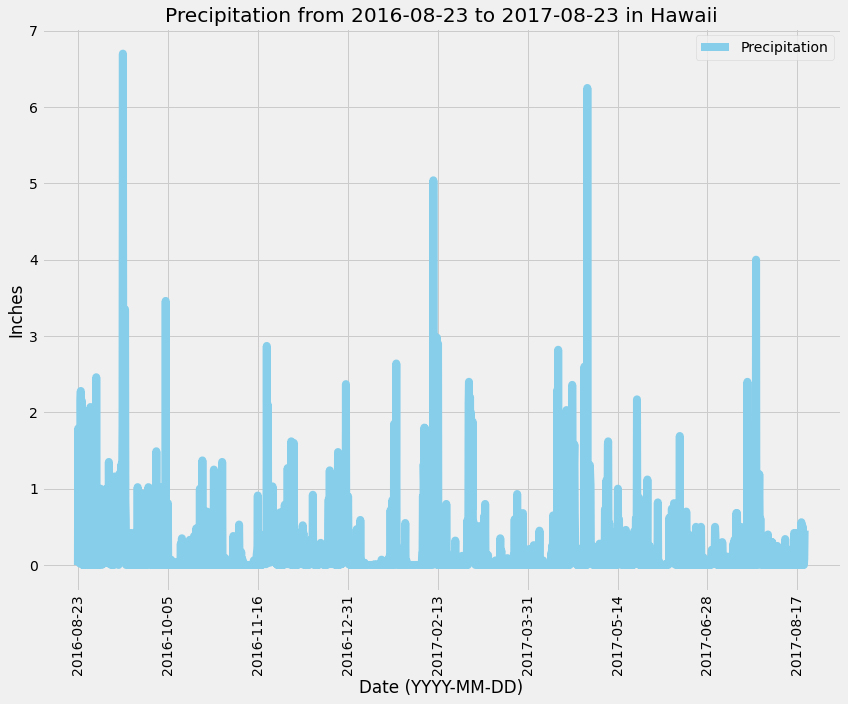

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Convert string to datetime
datetime_most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
print(datetime_most_recent_date)

# Calculate the date one year from the last date in data set.

datetime_one_year_ago = datetime_most_recent_date - dt.timedelta(days=365)
print(datetime_one_year_ago)

# Convert datetime to string
one_year_ago = datetime_one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores

scores = session.query(measurement.date, measurement.prcp).\
    filter((measurement.date <= most_recent_date) & (measurement.date >= one_year_ago)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column and sort by date

df_scores = pd.DataFrame(scores)
df_scores_renamed = df_scores.rename(columns = {'date' : 'Date', 'prcp' : 'Precipitation'})
df_scores_sorted = df_scores_renamed.sort_values(by=['Date'], ascending=True)
df_scores_clean = df_scores_sorted.set_index('Date')
df_scores_final = df_scores_clean.dropna()

# Use Pandas Plotting with Matplotlib to plot the data

prcp_fig = df_scores_final.plot(color = 'skyblue', figsize = (12,10), 
                                title= 'Precipitation from 2016-08-23 to 2017-08-23 in Hawaii', 
                                linewidth = 8, 
                                xlabel= "Date (YYYY-MM-DD)", 
                                ylabel= "Inches", 
                                grid = True)

plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df_scores_final.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Inspect the columns of Station

inspector = inspect(engine)
columns = inspector.get_columns('station')

for c in columns:
    print(c['name'], c['type'])
    

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Design a query to calculate the total number stations in the dataset

number_of_stations = session.query(func.count(station.id)).first()
print(number_of_stations)

(9,)


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_stations = session.query(measurement.station, func.count(measurement.date)).\
    group_by(measurement.station).order_by(func.count(measurement.date).desc()).all()

for a in active_stations:
    print(a)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_temp = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == active_stations[0][0]).all()

most_active_temp

[(54.0, 85.0, 71.66378066378067)]

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

active_recent = session.query(func.max(measurement.date)).\
    filter(measurement.station == active_stations[0][0]).first()

active_recent_date = active_recent[0]

dt_active_recent = dt.datetime.strptime(active_recent_date, '%Y-%m-%d')
dt_active_past = dt_active_recent - dt.timedelta(days = 365)

active_past_date = dt.datetime.strftime(dt_active_past, '%Y-%m-%d')

past_year = session.query(measurement.tobs).\
    filter(measurement.station == active_stations[0][0]).\
    filter((measurement.date >= active_past_date) & (measurement.date <= active_recent_date)).all()

new_list = []
for x in past_year:
    new_list.append(x[0])

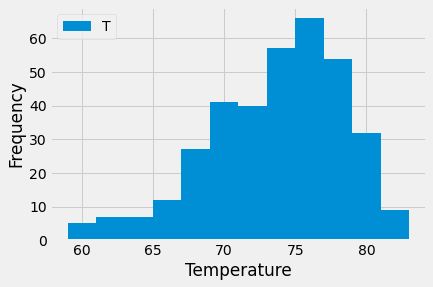

In [22]:
# Histogram

# bins = [0, 59, 60, 64, 65, 69, 70, 74, 75, 80]
# labels = [0, 60, 65, 70, 75, 80]

plt.hist(new_list, bins = 12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.legend('T', loc = 'upper left')


# Close session

In [23]:
# Close Session
session.close()